# Exemple 5

The purpose of this notebook is to compare the leaf area index dynamics simulated by the model in north Cameroon cropland extent, with NDVI dynamics measured by satellite. In this notebook, we will first have a look at this for one year, then do some magic to compute that for multiple years at once and use the correlation coefficient in between these data to calibrate by optimization both sowing date and variety phenological phasing.

## Imports

In [1]:
import numpy as np
import datetime
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm
import xarray as xr
from sarra_py import *
import geopandas as gpd
from joblib import Parallel, delayed
from contextlib import redirect_stdout, redirect_stderr
import rasterio as rio
import datetime
import cftime
from contextlib import redirect_stdout, redirect_stderr
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from bayes_opt import BayesianOptimization

## 2. Downloading and prepping example data

For this example, we provide rainfall and climate data for Senegal in 2013-2023, sourced from TAMSAT v3.1 for rainfall, and AgERA5 for climate ; the following cell will download it and unzip it. 

- climate data includes daily min, max, mean temperatures (°C), solar irradiance (W/m2), and reference evapotranspiration (mm), sourced from AgERA5
- rainfall data includes... rainfall data (mm), sourced from TAMSAT v3.1



In [2]:
import os
import urllib.request
import zipfile

# create a folder to store the data
os.makedirs('../data/exemple_data/exemple_5/', exist_ok=True)

# download preformatted data from Zenodo repository
url = 'https://zenodo.org/records/11092880/files/SARRA-Py_north_cameroon_2020_2022_example_data.zip?download=1'
local_filename = '../data/exemple_data/exemple_5/SARRA-Py_north_cameroon_2020_2022_example_data.zip' # store the downloaded file in the ../data/exemple_data/ folder
urllib.request.urlretrieve(url, local_filename)
print("File 1 downloaded using urllib.")

# unzip data
path_to_zip_file = "../data/exemple_data/exemple_5/SARRA-Py_north_cameroon_2020_2022_example_data.zip"
directory_to_extract_to = "../data/exemple_data/exemple_5/" # unzips the file in the same folder

with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)
print("File 1 unzipped.")

# download second preformatted data from Zenodo repository
url = 'https://zenodo.org/records/14637000/files/exemple_5_MODIS_NDVI_and_LULC_data.zip?download=1'
local_filename = '../data/exemple_data/exemple_5/exemple_5_MODIS_NDVI_and_LULC_data.zip' # store the downloaded file in the ../data/exemple_data/ folder
urllib.request.urlretrieve(url, local_filename)
print("File 2 downloaded using urllib.")

# unzip data
path_to_zip_file = "../data/exemple_data/exemple_5/exemple_5_MODIS_NDVI_and_LULC_data.zip"
directory_to_extract_to = "../data/exemple_data/exemple_5/" # unzips the file in the same folder

with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)
print("File 2 unzipped.")

File downloaded using urllib.
File unzipped.
File downloaded using urllib.
File unzipped.


In [3]:
# we set the paths to the data
rainfall_data_path = "../data/exemple_data/exemple_5/CHIRPS_v2.0_Africa_north_cameroon/"
climate_data_path = "../data/exemple_data/exemple_5/AgERA5_north_cameroon/"

In [5]:
import shutil

# we copy maize_cameroon_2020. yaml from the example folder to the ../data/params/itk/ folder 
shutil.copy("../data/exemple_data/exemple_5/itk_exemple_5.yaml", "../data/params/itk/itk_exemple_5.yaml")

# we copy maize_north_cameroon.yaml from the example folder to the ../data/params/variete/ folder
shutil.copy("../data/exemple_data/exemple_5/variety_exemple_5.yaml", "../data/params/variety/variety_exemple_5.yaml")

'../data/params/variety/variety_exemple_5.yaml'

## 3. Preparing the NDVI images

We requested and downloaded a NDVI time series dataset from NASA AppEEARS https://appeears.earthdatacloud.nasa.gov/ which is a 500m resolution MODIS NDVI product covering 2020 to 2022.

In [6]:
MODIS_data = xr.open_dataset("../data/exemple_data/exemple_5/MODIS_NDVI/MOD13A1.061_500m_aid0001.nc")
MODIS_data = MODIS_data.rio.write_crs("EPSG:4326")

# we convert the ugly cftime time labels to datetime.date labels
def convert_cftime(value):
    tuple = cftime.to_tuple(value)
    return datetime.date(tuple[0], tuple[1], tuple[2])

MODIS_data["time"] = [convert_cftime(x) for x in MODIS_data["time"].values]

We plot one date to vizualize

Skipping field centroid: unsupported OGR type: 3


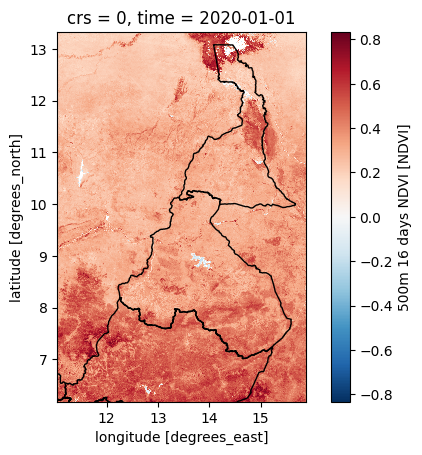

In [7]:
MODIS_data["_500m_16_days_NDVI"][1,:,:].plot()
gdf = gpd.read_file("https://fdw.fews.net/api/feature/?layer=1704&format=geojson")
gdf.plot(ax=plt.gca(), facecolor='none', edgecolor='black', linewidth=1.0)
plt.show()


We want to keep NDVI dynamics only for the cultivated land cover, so we also load a LULC product, Copernicus Global Land Cover, from downloaded from https://browser.dataspace.copernicus.eu/ at the "HIGH" analytical resolution (lat.: 0.0028576 deg/px (10.3sec/px), long.: 0.0029004 deg/px (10.4sec/px))). From this dataset, we only keep the info about the cropland extent.

In [8]:
LULC = xr.open_dataset("../data/exemple_data/exemple_5/Copernicus_cropland/2019-01-01-00_00_2019-01-01-23_59_Global_Land_Cover_Discrete_Classification_Map.tiff")
cropland = xr.where(LULC["band_data"][0,:,:] == 61681, 1, 0) # cropland is coded as 61681 in the LULC
del LULC # we delete the LULC dataset to free up memory

Plotting to have an idea of what we've got

Skipping field centroid: unsupported OGR type: 3


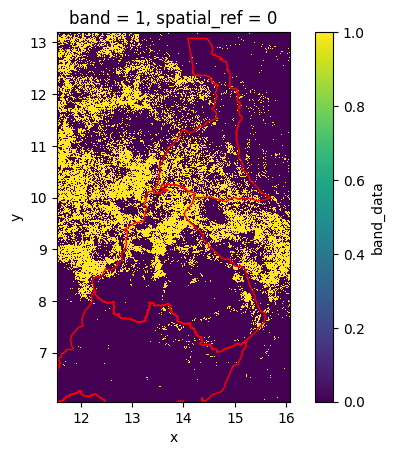

In [9]:
cropland.plot()
gdf = gpd.read_file("https://fdw.fews.net/api/feature/?layer=1704&format=geojson")
gdf.plot(ax=plt.gca(), facecolor='none', edgecolor='red', linewidth=1.0)
plt.show()


Now we will reproject and match the cropland product for it to have the same resolution as the MODIS product.

In [10]:
# set the coordinate reference system of the datasets
cropland = cropland.rio.write_crs("EPSG:4326") 
MODIS_data = MODIS_data.rio.write_crs("EPSG:4326")

# reproject
cropland = cropland.rio.reproject_match(MODIS_data, resampling=rio.enums.Resampling.nearest)

# rename cropland dims to lat and lon for consistency with MODIS
cropland = cropland.rename({"y":"lat", "x":"lon"})

We now perform masking of the MODIS data using the cropland mask, so that only NDVI values corresponding to cropland class are used.

In [11]:
masked_MODIS_data = xr.where(cropland == 1, MODIS_data["_500m_16_days_NDVI"], np.nan)

del MODIS_data # free up memory
del cropland # free up memory

Plotting the result

Skipping field centroid: unsupported OGR type: 3


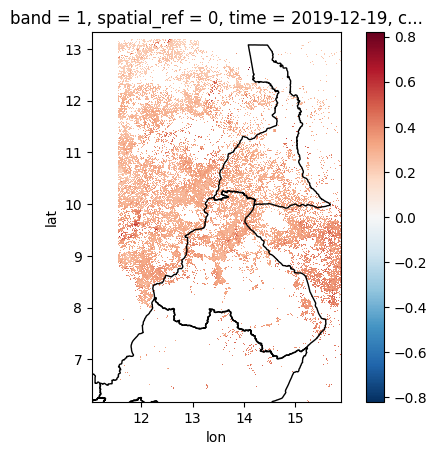

In [12]:
masked_MODIS_data[:,:,0].plot()
gdf = gpd.read_file("https://fdw.fews.net/api/feature/?layer=1704&format=geojson")
gdf.plot(ax=plt.gca(), facecolor='none', edgecolor='black', linewidth=1.0)
plt.show()

## 4. Performing NDVI comparison for year 2020

We select only the data from 2020

In [13]:
# select only the data from 2020
masked_MODIS_data_year = masked_MODIS_data.sel(time=slice(datetime.date(2020,1,1), datetime.date(2020,12,31)))

We perform a crop simulation for year 2020

In [14]:
year = 2020

# defining the simulation period (interval in which data is loaded)
# remember that we want to load data at least one month before the sowing date so that water balance can initialize properly
date_start = datetime.date(year,4,1) # 01/04/2017
duration = 365 - datetime.date(year,4,1).timetuple().tm_yday

grid_width, grid_height = get_grid_size(rainfall_data_path, date_start, duration) # get grid size 
base_data = xr.Dataset() # initialize empty xarray dataset
base_data = load_TAMSAT_data(base_data, rainfall_data_path, date_start, duration) # load rainfall data
base_data = load_AgERA5_data(base_data, climate_data_path, date_start, duration) # load climate data
base_data = load_iSDA_soil_data(base_data, grid_width, grid_height) # load soil parameters
base_data = calc_day_length_raster_fast(base_data, date_start, duration) # compute day length raster

# load variety, cropping system and soil parameters
file_paramVariete = "variety_exemple_4.yaml"
file_paramITK = "itk_exemple_4.yaml"
file_paramTypeSol = "USA_iowa_V42.yaml"
paramVariete, paramITK, paramTypeSol = load_YAML_parameters(file_paramVariete, file_paramITK, file_paramTypeSol)

data = base_data.copy() # creating simulation dataset by copying the base_data
paramITK["DateSemis"] = datetime.date(year, 8, 1)

# initializing all the necessary variables
data = initialize_simulation(data, grid_width, grid_height, duration, paramVariete, paramITK, date_start)
data = initialize_default_irrigation(data)
data = calculate_once_daily_thermal_time(data, paramVariete)

data = run_model(paramVariete, paramITK, paramTypeSol, data, duration) # running the model

  0%|          | 0/5 [00:00<?, ?it/s]

2m_temperature_24_hour_maximum
2m_temperature_24_hour_mean


 40%|████      | 2/5 [00:06<00:09,  3.33s/it]

2m_temperature_24_hour_minimum
ET0Hargeaves


 80%|████████  | 4/5 [00:12<00:03,  3.00s/it]

solar_radiation_flux_daily


100%|██████████| 273/273 [01:09<00:00,  3.93it/s]


In order to compare the MODIS data to our simulations, we have to match dimension names, add info about the CRS and reorder the dimensions of the dataset.

The resampling is done using the nearest neighbor approach, which may be criticised as we could have performed an averaging of values. However this is more complex to deploy as this is not natively able to manage nan values. So for the sake of this example we will stick to the nearest neighbor approach.

In [15]:
# manipulating metadata
masked_MODIS_data_year = masked_MODIS_data_year.rename({"lat":"y", "lon":"x"})
masked_MODIS_data_year = masked_MODIS_data_year.rio.write_crs("EPSG:4326")
masked_MODIS_data_year = masked_MODIS_data_year.transpose('time', 'y', 'x')

# performing the resampling
masked_MODIS_data_year_resampled = masked_MODIS_data_year.rio.reproject_match(data, resampling=rio.enums.Resampling.nearest)

Now that our MODIS data is at the resolution of our crop simulation, we will retrieve only the LAI at the locations where we have MODIS data (cropland extent).

In [16]:
# masked_lai = xr.where(~np.isnan(masked_MODIS_data_year_resampled[0,:,:]), data["lai"], np.nan)
masked_lai = xr.where(~np.isnan(masked_MODIS_data_year_resampled[0,:,:]), xr.where(data["numPhase"]!=0, data["lai"], np.nan), np.nan)

To compare the values from both time series, we create labels by converting the datetime.date objects from the masked_lai dataarray into a series of date of year (DOY) values, which are integers.

In [17]:
MODIS_DOY_labels = [x.timetuple().tm_yday for x in masked_MODIS_data_year_resampled["time"].values]

We create a dataframe in which we store for the MODIS NDVI values and simulated LAI values.

In [18]:
comparison_df = pd.DataFrame()

for i in range(len(MODIS_DOY_labels)):
    # Ensure the index is within the valid range
    lai_index = MODIS_DOY_labels[i] - date_start.timetuple().tm_yday
    if lai_index < 0 or lai_index >= masked_lai.shape[2]:
        continue
    date_df = pd.DataFrame({"MODIS": masked_MODIS_data_year_resampled[i,:,:].values.flatten(), "model": masked_lai[:,:,lai_index].values.flatten()})
    date_df["DOY"] = MODIS_DOY_labels[i]
    date_df["pixel_id"] = date_df.index
    comparison_df = pd.concat([comparison_df, date_df])

comparison_df = comparison_df.dropna().reset_index(drop=True)

We plot the obtained time series

<Figure size 1000x600 with 0 Axes>

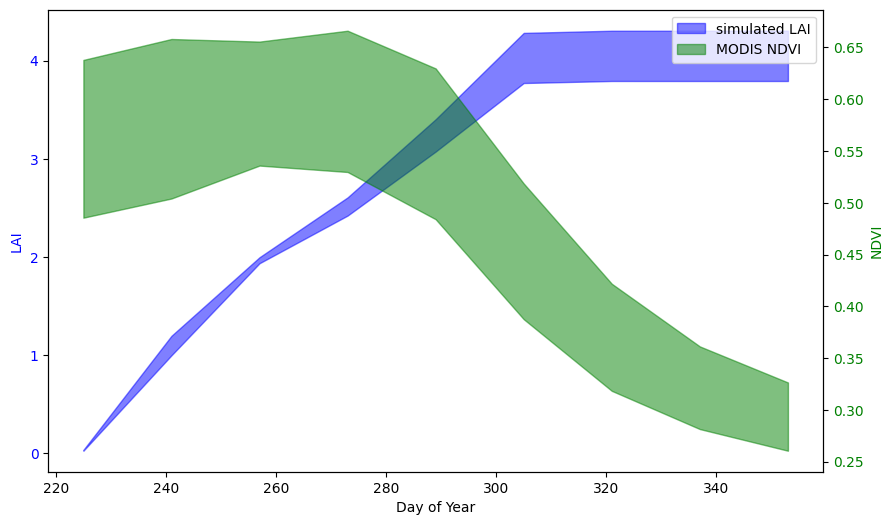

In [19]:
plt.figure(figsize=(10, 6))

# Calculate the 25th and 75th percentiles for each DOY
quantiles_model = comparison_df.groupby("DOY")["model"].quantile([0.25, 0.75]).unstack()
quantiles_MODIS = comparison_df.groupby("DOY")["MODIS"].quantile([0.25, 0.75]).unstack()

# Create the first y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the model data on the first y-axis
ax1.fill_between(quantiles_model.index, quantiles_model[0.25], quantiles_model[0.75], color='blue', alpha=0.5, label='simulated LAI')
ax1.set_xlabel("Day of Year")
ax1.set_ylabel("LAI", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create the second y-axis
ax2 = ax1.twinx()

# Plot the MODIS data on the second y-axis
ax2.fill_between(quantiles_MODIS.index, quantiles_MODIS[0.25], quantiles_MODIS[0.75], color='green', alpha=0.5, label='MODIS NDVI')
ax2.set_ylabel("NDVI", color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Add legends
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

plt.show()

Finally, we compute for each pixel a correlation coefficient between the NDVI time series and the simulated LAI. We calculate the mean values of this correlation coefficient for all pixels, which indicates to what extent all time series are correlated.

In [20]:
# compute pairwise correlation index between the model and MODIS data at the pixel_id level
correlation_per_pixel = comparison_df.groupby('pixel_id').apply(lambda x: x['model'].corr(x['MODIS']))
result = correlation_per_pixel.mean()

/tmp/ipykernel_967002/666875644.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlation_per_pixel = comparison_df.groupby('pixel_id').apply(lambda x: x['model'].corr(x['MODIS']))


## 5. Automatizing the comparison and using it to perform calibration through optimization

To automatize all the steps presented in 4, we basically encapsulate all the code inside a function.

In [27]:
def run_sim_and_compute_correspondance(year, delta_sowing, SDJBVP, SDJRPR, SDJMatu1):

    print(f"Running simulation for year {year} with sowing date {delta_sowing} and phenological stages {SDJBVP}, {SDJRPR}, {SDJMatu1}")

    # select only the data from 2020
    masked_MODIS_data_year = masked_MODIS_data.sel(time=slice(datetime.date(year,1,1), datetime.date(year,12,31)))

    with open(os.devnull, 'w') as devnull, redirect_stdout(devnull), redirect_stderr(devnull):

        # defining the simulation period (interval in which data is loaded)
        # remember that we want to load data at least one month before the sowing date so that water balance can initialize properly
        date_start = datetime.date(year,4,1) # 01/04/2017
        duration = 365 - datetime.date(year,4,1).timetuple().tm_yday

        grid_width, grid_height = get_grid_size(rainfall_data_path, date_start, duration) # get grid size 
        base_data = xr.Dataset() # initialize empty xarray dataset
        base_data = load_TAMSAT_data(base_data, rainfall_data_path, date_start, duration) # load rainfall data
        base_data = load_AgERA5_data(base_data, climate_data_path, date_start, duration) # load climate data
        base_data = load_iSDA_soil_data(base_data, grid_width, grid_height) # load soil parameters
        base_data = calc_day_length_raster_fast(base_data, date_start, duration) # compute day length raster

        # load variety, cropping system and soil parameters
        file_paramVariete = "variety_exemple_4.yaml"
        file_paramITK = "itk_exemple_4.yaml"
        file_paramTypeSol = "USA_iowa_V42.yaml"
        paramVariete, paramITK, paramTypeSol = load_YAML_parameters(file_paramVariete, file_paramITK, file_paramTypeSol)

        data = base_data.copy() # creating simulation dataset by copying the base_data
        paramITK["DateSemis"] = datetime.date(year, 4, 1) + datetime.timedelta(days=int(np.round(delta_sowing, 0)))
        paramITK["SDJBVP"] = SDJBVP
        paramITK["SDJRPR"] = SDJRPR
        paramITK["SDJMatu1"] = SDJMatu1

        # initializing all the necessary variables
        data = initialize_simulation(data, grid_width, grid_height, duration, paramVariete, paramITK, date_start)
        data = initialize_default_irrigation(data)
        data = calculate_once_daily_thermal_time(data, paramVariete)

    data = run_model(paramVariete, paramITK, paramTypeSol, data, duration) # running the model

    # manipulating metadata
    masked_MODIS_data_year = masked_MODIS_data_year.rename({"lat":"y", "lon":"x"})
    masked_MODIS_data_year = masked_MODIS_data_year.rio.write_crs("EPSG:4326")
    masked_MODIS_data_year = masked_MODIS_data_year.transpose('time', 'y', 'x')

    # performing the resampling
    masked_MODIS_data_year_resampled = masked_MODIS_data_year.rio.reproject_match(data, resampling=rio.enums.Resampling.nearest)
    masked_lai = xr.where(~np.isnan(masked_MODIS_data_year_resampled[0,:,:]), xr.where(data["numPhase"]!=0, data["lai"], np.nan), np.nan)
    MODIS_DOY_labels = [x.timetuple().tm_yday for x in masked_MODIS_data_year_resampled["time"].values]

    comparison_df = pd.DataFrame()

    for i in range(len(MODIS_DOY_labels)):
        # Ensure the index is within the valid range
        lai_index = MODIS_DOY_labels[i] - date_start.timetuple().tm_yday
        if lai_index < 0 or lai_index >= masked_lai.shape[2]:
            continue
        date_df = pd.DataFrame({"MODIS": masked_MODIS_data_year_resampled[i,:,:].values.flatten(), "model": masked_lai[:,:,lai_index].values.flatten()})
        date_df["DOY"] = MODIS_DOY_labels[i]
        date_df["pixel_id"] = date_df.index
        comparison_df = pd.concat([comparison_df, date_df])

    comparison_df = comparison_df.dropna().reset_index(drop=True)

    # compute pairwise correlation index between the model and MODIS data at the pixel_id level
    correlation_per_pixel = comparison_df.groupby('pixel_id').apply(lambda x: x['model'].corr(x['MODIS']))
    result = correlation_per_pixel.mean()

    return result

We define a black box/objective function, which objective is to parallel launch the crop simulations for multiple years at once, gather results and calculate our metric to optimize. Here, we chose Pearson correlation as LAI and NDVI are known to be linked by a linear relationship, but being values of different order of magnitude.

In [28]:
def geo_mean(iterable):
    a = np.array(iterable)
    return a.prod()**(1.0/len(a))

def eval_function(delta_sowing, SDJBVP, SDJRPR, SDJMatu1):

    years = [2020, 2021, 2022]
    n_jobs = 3
    results = Parallel(n_jobs)(delayed(run_sim_and_compute_correspondance)(year, delta_sowing, SDJBVP, SDJRPR, SDJMatu1) for year in years)
    return geo_mean(results)

We define the boundaries in between which we want to perform the optimization, and launch the process.

In [ ]:
# KrdtPotA: 0.9 # original 0.9 - entre 0.35 et 1.2
# SDJBVP: 500.0 # original 500 - entre 200 et 500 
# SDJRPR: 400.0 # original 400 - entre 360 et 630
# SDJMatu1: 500.0 # original 500 - entre 370 et 900

pbounds = {'delta_sowing': (0, 60),
           'SDJBVP': (200, 500),
           'SDJRPR': (360, 630),
           'SDJMatu1': (370, 900)}

optimizer = BayesianOptimization(
    f=eval_function,
    pbounds=pbounds,
    random_state=1,
)

logger = JSONLogger(path="./exemple_5_logs.log")
optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)

# probing a point that was returning good results
optimizer.probe(
    params={"SDJBVP": 229.14571580980143, "SDJMatu1": 781.0172942556815, "SDJRPR": 628.9688233746203, "delta_sowing": 32.3323289898732},
    lazy=True,
)

optimizer.maximize(
    init_points=5,
    n_iter=25,
)

Best results : 

{"target": 0.76049957682304, "params": {"SDJBVP": 227.5056311367069, "SDJMatu1": 807.2947663232696, "SDJRPR": 619.2405573229876, "delta_sowing": 35.4979648771293}, "datetime": {"datetime": "2025-01-10 19:32:40", "elapsed": 9088.511173, "delta": 265.502233}}


# 6. Looking at some results

Finally, we use the best obtained results to make a simulation and look at the outcomes.

In [30]:
# we define an alternate function to generate results (it exports the dataframe of comparison between simulated LAI and MODIS NDVI)

def run_sim_and_compute_correspondance_2(year, delta_sowing, SDJBVP, SDJRPR, SDJMatu1):

    print(f"Running simulation for year {year} with sowing date {delta_sowing} and phenological stages {SDJBVP}, {SDJRPR}, {SDJMatu1}")

    # select only the data from 2020
    masked_MODIS_data_year = masked_MODIS_data.sel(time=slice(datetime.date(year,1,1), datetime.date(year,12,31)))

    with open(os.devnull, 'w') as devnull, redirect_stdout(devnull), redirect_stderr(devnull):

        # defining the simulation period (interval in which data is loaded)
        # remember that we want to load data at least one month before the sowing date so that water balance can initialize properly
        date_start = datetime.date(year,4,1) # 01/04/2017
        duration = 365 - datetime.date(year,4,1).timetuple().tm_yday

        grid_width, grid_height = get_grid_size(rainfall_data_path, date_start, duration) # get grid size 
        base_data = xr.Dataset() # initialize empty xarray dataset
        base_data = load_TAMSAT_data(base_data, rainfall_data_path, date_start, duration) # load rainfall data
        base_data = load_AgERA5_data(base_data, climate_data_path, date_start, duration) # load climate data
        base_data = load_iSDA_soil_data(base_data, grid_width, grid_height) # load soil parameters
        base_data = calc_day_length_raster_fast(base_data, date_start, duration) # compute day length raster

        # load variety, cropping system and soil parameters
        file_paramVariete = "variety_exemple_4.yaml"
        file_paramITK = "itk_exemple_4.yaml"
        file_paramTypeSol = "USA_iowa_V42.yaml"
        paramVariete, paramITK, paramTypeSol = load_YAML_parameters(file_paramVariete, file_paramITK, file_paramTypeSol)

        data = base_data.copy() # creating simulation dataset by copying the base_data
        paramITK["DateSemis"] = datetime.date(year, 4, 1) + datetime.timedelta(days=int(np.round(delta_sowing, 0)))
        paramITK["SDJBVP"] = SDJBVP
        paramITK["SDJRPR"] = SDJRPR
        paramITK["SDJMatu1"] = SDJMatu1

        # initializing all the necessary variables
        data = initialize_simulation(data, grid_width, grid_height, duration, paramVariete, paramITK, date_start)
        data = initialize_default_irrigation(data)
        data = calculate_once_daily_thermal_time(data, paramVariete)

    data = run_model(paramVariete, paramITK, paramTypeSol, data, duration) # running the model

    # manipulating metadata
    masked_MODIS_data_year = masked_MODIS_data_year.rename({"lat":"y", "lon":"x"})
    masked_MODIS_data_year = masked_MODIS_data_year.rio.write_crs("EPSG:4326")
    masked_MODIS_data_year = masked_MODIS_data_year.transpose('time', 'y', 'x')

    # performing the resampling
    masked_MODIS_data_year_resampled = masked_MODIS_data_year.rio.reproject_match(data, resampling=rio.enums.Resampling.nearest)
    masked_lai = xr.where(~np.isnan(masked_MODIS_data_year_resampled[0,:,:]), xr.where(data["numPhase"]!=0, data["lai"], np.nan), np.nan)
    MODIS_DOY_labels = [x.timetuple().tm_yday for x in masked_MODIS_data_year_resampled["time"].values]

    comparison_df = pd.DataFrame()

    for i in range(len(MODIS_DOY_labels)):
        # Ensure the index is within the valid range
        lai_index = MODIS_DOY_labels[i] - date_start.timetuple().tm_yday
        if lai_index < 0 or lai_index >= masked_lai.shape[2]:
            continue
        date_df = pd.DataFrame({"MODIS": masked_MODIS_data_year_resampled[i,:,:].values.flatten(), "model": masked_lai[:,:,lai_index].values.flatten()})
        date_df["DOY"] = MODIS_DOY_labels[i]
        date_df["pixel_id"] = date_df.index
        comparison_df = pd.concat([comparison_df, date_df])

    comparison_df = comparison_df.dropna().reset_index(drop=True)

    # # compute pairwise correlation index between the model and MODIS data at the pixel_id level
    # correlation_per_pixel = comparison_df.groupby('pixel_id').apply(lambda x: x['model'].corr(x['MODIS']))
    # result = correlation_per_pixel.mean()

    return comparison_df

Running the simulation for the best obtained results for optimization.

In [ ]:
# best result : {"target": 0.76049957682304, "params": {"SDJBVP": 227.5056311367069, "SDJMatu1": 807.2947663232696, "SDJRPR": 619.2405573229876, "delta_sowing": 35.4979648771293}, "datetime": {"datetime": "2025-01-10 19:32:40", "elapsed": 9088.511173, "delta": 265.502233}}
year = 2020
delta_sowing = 35.4979648771293
SDJBVP = 227.5056311367069
SDJRPR = 619.2405573229876
SDJMatu1 = 807.2947663232696
comparison_df = run_sim_and_compute_correspondance_2(year, delta_sowing, SDJBVP, SDJRPR, SDJMatu1)

Running simulation for year 2020 with sowing date 35.4979648771293 and phenological stages 227.5056311367069, 619.2405573229876, 807.2947663232696


100%|██████████| 273/273 [01:21<00:00,  3.35it/s]


Making a ribbon plot for the time series

<Figure size 1000x600 with 0 Axes>

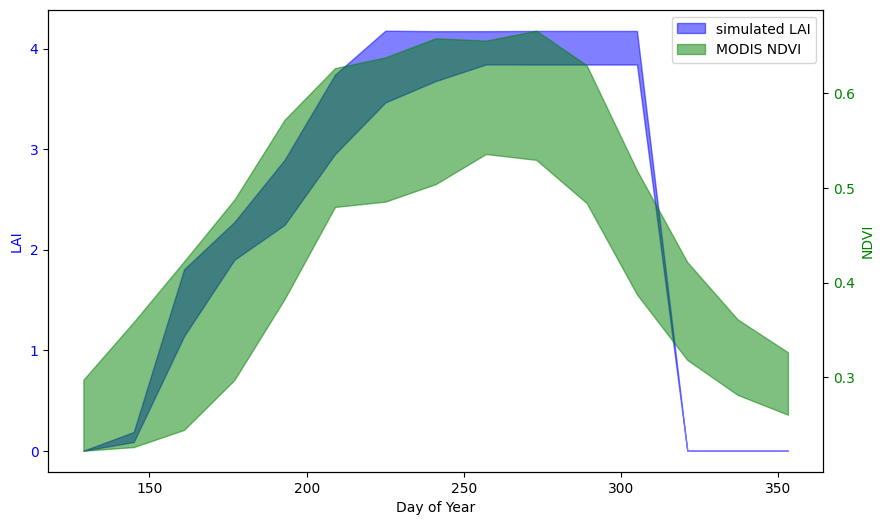

In [ ]:
plt.figure(figsize=(10, 6))

# Calculate the 25th and 75th percentiles for each DOY
quantiles_model = comparison_df.groupby("DOY")["model"].quantile([0.25, 0.75]).unstack()
quantiles_MODIS = comparison_df.groupby("DOY")["MODIS"].quantile([0.25, 0.75]).unstack()

# Create the first y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the model data on the first y-axis
ax1.fill_between(quantiles_model.index, quantiles_model[0.25], quantiles_model[0.75], color='blue', alpha=0.5, label='simulated LAI')
ax1.set_xlabel("Day of Year")
ax1.set_ylabel("LAI", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create the second y-axis
ax2 = ax1.twinx()

# Plot the MODIS data on the second y-axis
ax2.fill_between(quantiles_MODIS.index, quantiles_MODIS[0.25], quantiles_MODIS[0.75], color='green', alpha=0.5, label='MODIS NDVI')
ax2.set_ylabel("NDVI", color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Add legends
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

plt.show()